In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from scipy import sparse
from timesteppers import *
from field import *
from spatial import *

In [6]:
%run -i fokkerplanck.py

In [2]:
def ornstein_uhlenbeck_sol(gamma,D,mu,t,x,x0):
    a = np.sqrt(gamma/(2*np.pi*D*(1-np.exp(-2*gamma*(t))))) 
    b = np.exp(-1*(gamma*(x-np.exp(-gamma*t)*x0)**2)/(2*D*(1-np.exp(-2*gamma*t))))
    return a * b

def Wiener_sol(D,t,t0,x,x0):
    return 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0)**2/(4*D*(t-t0)))

def Wiener_drift_sol(gamma, D,t,t0,x,x0):
    return 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0-gamma*(t-t0))**2/(4*D*(t-t0))) # with a drift x

# def gaussian_ic(x,x0,y,y0,sigma=2.):
#     r = (x-x0)**2. + (y-y0)**2.
#     return np.exp(-r/sigma**2.)

## Wiener Process

In [5]:
def run_wiener(params, alpha, resolution):
    x0, t0, D, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(16,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    IC = Wiener_sol(D, t0, 0, x, x0) + 0*y


    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    # mu = Array(domain, x*0 + y*0)
    mu = Array(domain, x*0 + y*0)
    D_arr  = Array(domain, D + x*0 + y*0)

    mu_i = [mu, mu]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    target = Wiener_sol(D,diff.t+t0,t0,x,x0) + 0*y
    return x, target, p.data, IC

/hpctmp/e0974164/modisco/lib/python3.9/site-packages/scipy-1.9.1-py3.9-linux-x86_64.egg/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


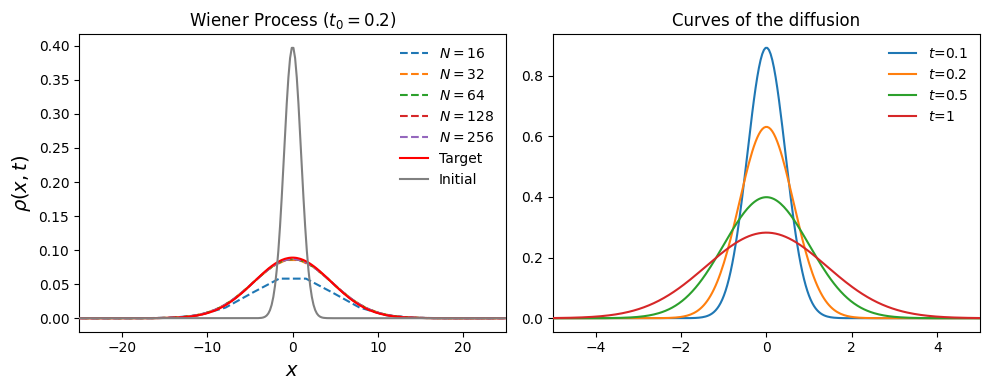

: 

In [5]:
resolutions = [16, 32, 64, 128, 256]
alpha       = 0.8


### User parameters

# physical
# x0 = 8*np.pi
t0 = 0.5
x0=0
# t0=2
# D  = 0.5
D = 1

# numerical
spatial_order = 2

# domain
# xmin = 0
# xmax = 16*np.pi
# ymin = 0
# ymax = 16*np.pi
xmin = -8*np.pi
xmax = 8*np.pi
ymin = -8*np.pi
ymax = 8*np.pi

# solution
tmax = 10-1e-5

## combine params to send to wiener problem

params = x0, t0, D, spatial_order, xmin, xmax, ymin, ymax, tmax


fig, ax = plt.subplots(1, 2, figsize=(10,4))

error = []
norm  = 1.
for resolution in resolutions:
    x, target, sol, ic = run_wiener(params, alpha, resolution)
    dx = x[1] - x[0]
    error.append(np.sum(dx*np.abs(sol[:,8]-target[:,8])**norm)**(1/norm))
    ax[0].plot(x, sol[:,8],label=r'$N = %d$' % resolution, ls='--')
        
ax[0].plot(x, target[:,8],color='r',label=r'Target',zorder=10)
# ax[1].plot(x, ic[:,8],label='t=1',zorder=10)
ax[0].plot(x, ic[:,8],color='grey',label=r'Initial',zorder=10)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$x$',fontsize=14)
# ax[0].set_ylabel(r'$f(x)$',fontsize=14)
ax[0].set_ylabel(r'$\rho(x,t)$',fontsize=14)
ax[0].set_xlim(x[0],x[-1])
ax[0].set_title(r'Wiener Process $(t_0=0.2)$')


t_span = [0.1,0.2,0.5,1]
for t0 in t_span:
    params = x0, t0, D, spatial_order, -5, 5, ymin, ymax, tmax
    x, target, sol, ic = run_wiener(params, alpha, 256)
    ax[1].plot(x, ic[:,8],label=f'$t$={t0}',zorder=10)

ax[1].legend(frameon=False)
ax[1].set_xlim(-5,5)
ax[1].set_title('Curves of the diffusion')
## extra plot stuff
#ax[0].set_title('test')

# fig.suptitle('Wiener Process')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
# if 0:
#     plt.savefig('fp_wp_1d.pdf')

plt.savefig('fp_wp_1d.pdf', dpi=300)

In [12]:
def run_wiener_drift(params, alpha, resolution):
    x0, t0, gamma, D, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(16,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    IC = Wiener_drift_sol(gamma, D, t0, 0, x, x0) + 0*y


    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    # mu = Array(domain, x*0 + y*0)
    mu = Array(domain, gamma + x*0 + y*0)
    D_arr  = Array(domain, D + x*0 + y*0)

    mu_i = [mu, mu]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    target = Wiener_drift_sol(gamma,D,diff.t+t0,t0,x,x0) + 0*y
    return x, target, p.data, IC

/hpctmp/e0974164/modisco/lib/python3.9/site-packages/scipy-1.9.1-py3.9-linux-x86_64.egg/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


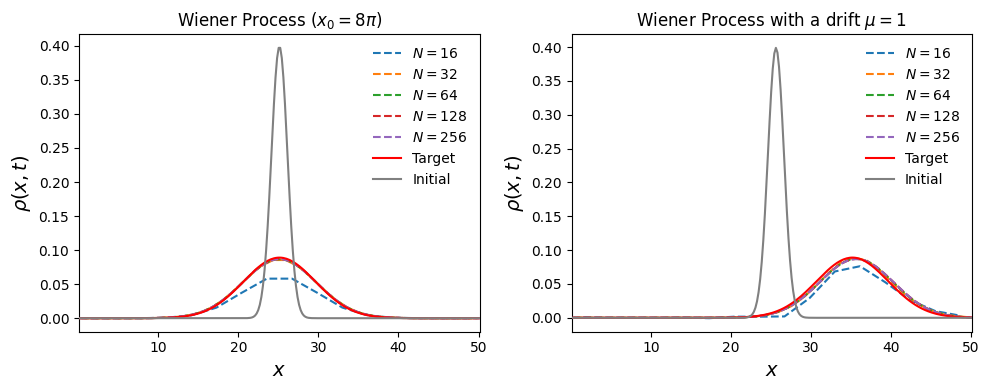

In [8]:
def Wiener_sol(D,t,t0,x,x0):
    return 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0)**2/(4*D*(t-t0)))

def Wiener_drift_sol(gamma, D,t,t0,x,x0):
    return 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0-gamma*(t-t0))**2/(4*D*(t-t0))) # with a drift x

'''
Test Wiener solution for Fokker-Planck equation on 2D grid
'''

def run_wiener(params, alpha, resolution):
    x0, t0, D, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(16,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()

    IC = Wiener_sol(D, t0, 0, x, x0) + 0*y

    p = Field(domain)
    X = FieldSystem([p])

    p.data[:] = np.copy(IC)

    # mu = Array(domain, x*0 + y*0)
    mu = Array(domain, x*0 + y*0)
    D_arr  = Array(domain, D + x*0 + y*0)

    mu_i = [mu, mu]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running

    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    target = Wiener_sol(D,diff.t+t0,t0,x,x0) + 0*y
    return x, target, p.data, IC



def run_wiener_drift(params, alpha, resolution):
    x0, t0, gamma, D, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(16,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    IC = Wiener_drift_sol(gamma, D, t0, 0, x, x0) + 0*y


    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    # mu = Array(domain, x*0 + y*0)
    mu = Array(domain, gamma + x*0 + y*0)
    D_arr  = Array(domain, D + x*0 + y*0)

    mu_i = [mu, mu]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    target = Wiener_drift_sol(gamma,D,diff.t+t0,t0,x,x0) + 0*y
    return x, target, p.data, IC

resolutions = [16, 32, 64, 128, 256]
alpha       = 0.8


### User parameters

# physical
x0 = 8*np.pi
t0 = 0.5
# t0=2
# D  = 0.5
D = 1

gamma = 1

# numerical
spatial_order = 2

# domain
xmin = 0
xmax = 16*np.pi
ymin = 0
ymax = 16*np.pi

# solution
tmax = 10-1e-5

## combine params to send to wiener problem

params = x0, t0, D, spatial_order, xmin, xmax, ymin, ymax, tmax


fig, ax = plt.subplots(1, 2, figsize=(10,4))

error = []
norm  = 1.
for resolution in resolutions:
    x, target, sol, ic = run_wiener(params, alpha, resolution)
    dx = x[1] - x[0]
    error.append(np.sum(dx*np.abs(sol[:,8]-target[:,8])**norm)**(1/norm))
    ax[0].plot(x, sol[:,8],label=r'$N = %d$' % resolution, ls='--')
        
ax[0].plot(x, target[:,8],color='r',label=r'Target',zorder=10)
# ax[1].plot(x, ic[:,8],label='t=1',zorder=10)
ax[0].plot(x, ic[:,8],color='grey',label=r'Initial',zorder=10)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$x$',fontsize=14)
# ax[0].set_ylabel(r'$f(x)$',fontsize=14)
ax[0].set_ylabel(r'$\rho(x,t)$',fontsize=14)
ax[0].set_xlim(x[0],x[-1])
ax[0].set_title(r'Wiener Process ($x_0=8\pi$)')


## combine params to send to wiener problem

params = x0, t0, D, gamma, spatial_order, xmin, xmax, ymin, ymax, tmax

for resolution in resolutions:
    x, target, sol, ic = run_wiener_drift(params, alpha, resolution)
    dx = x[1] - x[0]
    error.append(np.sum(dx*np.abs(sol[:,8]-target[:,8])**norm)**(1/norm))
    ax[1].plot(x, sol[:,8],label=r'$N = %d$' % resolution, ls='--')
        
ax[1].plot(x, target[:,8],color='r',label=r'Target',zorder=10)
ax[1].plot(x, ic[:,8],color='grey',label=r'Initial',zorder=10)
ax[1].legend(frameon=False)
ax[1].set_xlabel(r'$x$',fontsize=14)
ax[1].set_ylabel(r'$\rho(x,t)$',fontsize=14)
ax[1].set_xlim(x[0],x[-1])
ax[1].set_title(r'Wiener Process with a drift $\mu=1$')

## extra plot stuff
#ax[0].set_title('test')

# fig.suptitle('Wiener Process')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
# if 0:
#     plt.savefig('fp_wp_1d.pdf')

plt.savefig('fp_wp_drift.pdf', dpi=300)

## Ornstein-Uhlenbeck Process

In [19]:
def ornstein_uhlenbeck_sol(gamma,D,t,x,x0):
    a = np.sqrt(gamma/(2*np.pi*D*(1-np.exp(-2*gamma*t)))) 
    b = np.exp(-1*(gamma*(x-np.exp(-gamma*t)*x0)**2)/(2*D*(1-np.exp(-2*gamma*t))))
    return a * b



def run_ou(params, alpha, resolution):
    x0, t0, gamma, D, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(16,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    IC = ornstein_uhlenbeck_sol(gamma, D, t0, x, x0) + 0*y

    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    mu = Array(domain, -1*gamma*x + y*0)
    D_arr  = Array(domain, D + x*0 + y*0)
    
    mu_i = [mu, mu]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    target = ornstein_uhlenbeck_sol(gamma, D, diff.t+t0, x, x0) + 0*y
    return x, target, p.data, IC

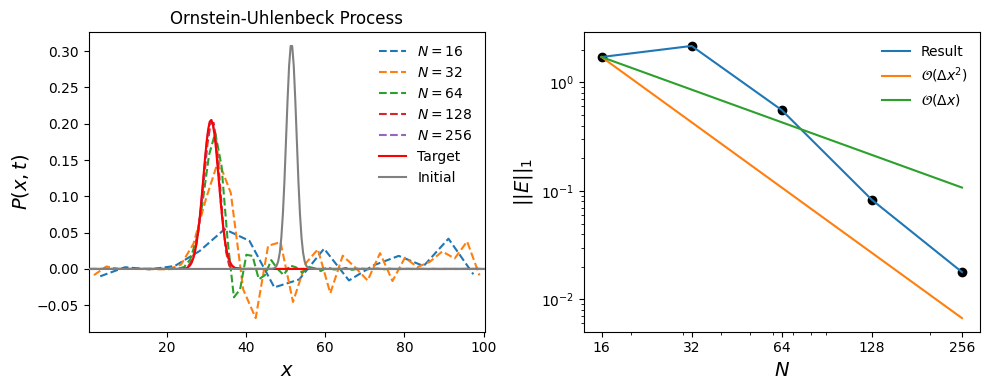

In [26]:
resolutions = [16, 32, 64, 128, 256]
alpha       = 0.2


### User parameters

# physical
x0    = 20*np.pi
t0    = 2
D     = 0.5
gamma = 0.1

# numerical
spatial_order = 2

# domain
xmin = 0
xmax = 32*np.pi
ymin = 0
ymax = 32*np.pi

# solution
tmax = 5-1e-5

## combine params to send to wiener problem

params = x0, t0, gamma, D, spatial_order, xmin, xmax, ymin, ymax, tmax

error = []
norm  = 1.

fig, ax = plt.subplots(1, 2, figsize=(10,4))

for resolution in resolutions:
    x, target, sol, ic = run_ou(params, alpha, resolution)
    dx = x[1] - x[0]
    error.append(np.sum(dx*np.abs(sol[:,8]-target[:,8])**norm)**(1/norm))
    ax[0].plot(x, sol[:,8],label=r'$N = %d$' % resolution, ls='--', zorder=1)
    
ax[0].plot(x, target[:,8],color='r',label=r'Target',zorder=10)
ax[0].plot(x, ic[:,8],color='grey',label=r'Initial',zorder=10)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$x$',fontsize=14)
ax[0].set_ylabel(r'$P(x, t)$',fontsize=14)
ax[0].set_xlim(x[0],x[-1])
ax[0].set_title('Ornstein-Uhlenbeck Process')

ax[1].plot(resolutions,error,label='Result')
ax[1].scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

ax[1].plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
ax[1].plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(frameon=False)

xtick_labels = np.array(resolutions).astype(str)
ax[1].set_xlabel(r'$N$',fontsize=14)
ax[1].set_ylabel(r'$||E||_1$',fontsize=14)
ax[1].set_xticks(resolutions)
ax[1].set_xticklabels(xtick_labels)

## extra plot stuff
#ax[0].set_title('test')

# fig.suptitle('Ornstein-Uhlenbeck Process')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig('fp_ou_1d.pdf', dpi=300)

In [ ]:
plt.plot(resolutions,error,label='Result')
plt.scatter(resolutions,error, color='black')

dx2_arr = np.array(resolutions)**(-2.)
dx1_arr = np.array(resolutions)**(-1.)

dx2_arr = dx2_arr * error[0]/dx2_arr[0]
dx1_arr = dx1_arr * error[0]/dx1_arr[0]

plt.plot(resolutions,dx2_arr,label=r'$\mathcal{O}(\Delta x^2)$')
plt.plot(resolutions,dx1_arr,label=r'$\mathcal{O}(\Delta x)$')

plt.yscale('log')
plt.xscale('log')
plt.legend(frameon=False)

In [7]:
def gaussian_ic(x,x0,y,y0,sigma=2.):
    r = (x-x0)**2. + (y-y0)**2.
    
    return np.exp(-r/sigma**2.)

In [8]:
def run_example_problem(params, alpha, resolution):
    x0, y0, t0, spatial_order, xmin, xmax, ymin, ymax, tmax = params
    
    ### Setting up the problem
    
    grid_x = UniformNonPeriodicGrid(resolution,[xmin, xmax])
    grid_y = UniformNonPeriodicGrid(resolution,[ymin, ymax])
    domain = Domain([grid_x, grid_y])
    x,y = domain.values()


    #IC = ornstein_uhlenbeck_sol(gamma, D, t0, x, x0) + 0*y
    IC  = gaussian_ic(x, x0, y, y0, sigma=4)
    
    
    p = Field(domain)
    X = FieldSystem([p])


    p.data[:] = np.copy(IC)

    mu1 = Array(domain, -0.1*x)
    mu2 = Array(domain, -0.1*y)

    D_arr  = Array(domain, 0.5 + x*0 + y*0)#(x-x0 + 0.1)**(-2.) + (y - y0 + 0.1)**(-2.))
    
    mu_i = [mu1, mu2]
    D_ij = [[D_arr, D_arr],
            [D_arr, D_arr]]
    diff = FokkerPlanck_2D(X,mu_i,D_ij)

    ### Running


    dt = alpha * domain.grids[0].dx
    while diff.t < tmax:
        diff.step(dt)
        
    return x, p.data, IC